<a href="https://colab.research.google.com/github/dhruvphansalkar/6301Project/blob/main/Reduced_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
data_path = os.path.join(os.getcwd(), "drive", "My Drive", "cs6301-sp23", "project_data", "data", "MergeResult_3.tsv")

Mounted at /content/drive


In [ ]:
!pip install transformers datasets evaluate
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:

import os
from pathlib import Path

import numpy as np
import nltk
nltk.download("punkt")
import pandas as pd
from datasets import Dataset, load_metric
from datasets.load import load_dataset
from transformers import AutoTokenizer
import preprocessor as p
from transformers import TrainingArguments, Trainer

from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def fetch_data_from_csv(path):
  df = pd.read_table(path)
  df = pd.DataFrame(df)
  #return Dataset.from_pandas(df)
  return df

In [ ]:
def convertDFtoDataSet(df):
  ds = Dataset.from_pandas(df)
  return ds

In [ ]:
data = fetch_data_from_csv(data_path)

In [ ]:
def reduceClasses(classVal):
  if classVal == 'other_useful_information' or classVal == 'caution_and_advice' or classVal == 'sympathy_and_emotional_support' or classVal == 'not_related_or_irrelevant':
    return 'not_related_or_irrelevant'
  elif classVal == 'injured_or_dead_people' or classVal == 'missing_trapped_or_found_people' or classVal == 'infrastructure_and_utilities_damage':
    return 'emergency_services_required'
  else:
    return 'donation_needs_or_offers_or_volunteering_services'
  

In [ ]:
data['label'] = data['label'].apply(lambda lab: reduceClasses(lab))

In [ ]:
def understandData(df):
  print('--------------------------------Shape of the data is--------------------------')
  print(data.shape)

  print('----------------------the data contains following fields----------------------')
  print(data.columns)

  print('---------------------------------Data Description-----------------------------')
  print(data.describe)

  print('---------------------------------label count----------------------------------')
  print(data['label'].value_counts())

In [ ]:
understandData(data)

--------------------------------Shape of the data is--------------------------
(17382, 3)
----------------------the data contains following fields----------------------
Index(['tweet_id', 'tweet_text', 'label'], dtype='object')
---------------------------------Data Description-----------------------------
<bound method NDFrame.describe of                    tweet_id  \
0      '383600460340666369'   
1      '383790723222364161'   
2      '384232048124518400'   
3      '384860484643475456'   
4      '383407962619772928'   
...                     ...   
17377  '592126024437125121'   
17378  '593819547372638208'   
17379  '592137869482799104'   
17380  '591936980096659456'   
17381  '592344448887029761'   

                                                                                                                                         tweet_text  \
0      RT @Faiz_Baluch: #BalochistanEarthQuake Pakistan army is terrorizing the people by aerial firing in #Awaran https://t.co/R3R5ph8

In [ ]:
id2label = {0: 'not_related_or_irrelevant', 1: 'emergency_services_required', 2: 'donation_needs_or_offers_or_volunteering_services'}
label2id = {'not_related_or_irrelevant': 0, 'emergency_services_required': 1, 'donation_needs_or_offers_or_volunteering_services': 2}

In [ ]:
def exploratoryAnalysis(df):
  
  plt.figure(figsize=(8,6))
  sns.set_style(style='darkgrid')
  ax = sns.countplot(x = 'label', data = df)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  plt.tight_layout()
  plt.title('Class Distribution')
  plt.show()

  plt.figure(figsize=(6,8))
  sns.set_style("darkgrid")
  df['label'].value_counts().plot.pie(autopct='%0.2f%%')
  plt.title("Percentage Contribution")
  plt.xlabel("percent contribution")
  plt.ylabel("label")
  plt.show()

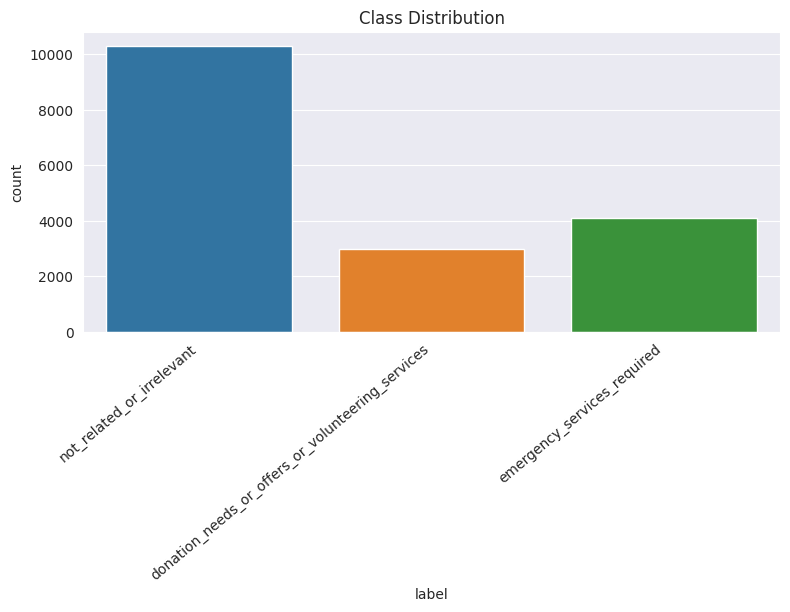

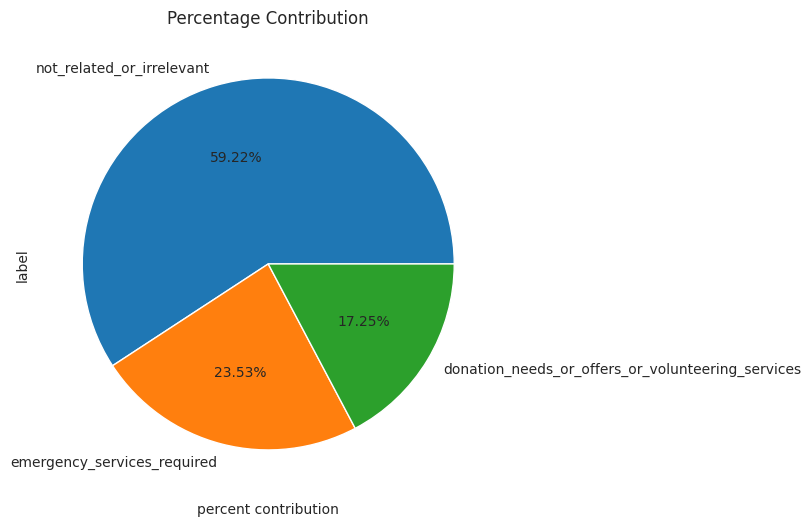

In [ ]:
exploratoryAnalysis(data)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
nltk.download('stopwords')
stopwords=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def cleaner(text):

    cleaned = p.clean(text)
    cleaned=cleaned.replace("//"," ").replace("."," ")
    cleaned=re.sub(r'[^a-zA-Z]'," ",cleaned)
    cleaned=cleaned.strip() #removing whitespace
    cleaned=cleaned.lower() #converting into lower case words
    cleaned=re.sub(r'\w+\d+'," ",cleaned)#remove alphanumeric words
    cleaned=ps.stem(cleaned) #stemming 
    cleaned=[word for word in cleaned.split() if len(word)>2]
    cleaned=" ".join(cleaned)
    return cleaned

In [ ]:
#cleaning data
data['tweet_text'] = data['tweet_text'].apply(lambda text:cleaner(text))

In [ ]:
#converting label to id
def labeltoId(label):
  return label2id[label]

data['label'] = data['label'].apply(lambda label: labeltoId(label))

In [ ]:
dataset_data = convertDFtoDataSet(data)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
def tokenize_data(dataset_data):
    return tokenizer(dataset_data["tweet_text"], padding='max_length')

In [ ]:
tokenized_data = dataset_data.map(tokenize_data, batched = True)

Map:   0%|          | 0/17382 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
tokenized_data = tokenized_data.train_test_split(test_size=0.1)
train_d = tokenized_data['train'].shuffle(seed=10)
eval_d = tokenized_data['test'].shuffle(seed=10)

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
training_args = TrainingArguments(
    "test_trainer", 
    num_train_epochs=1,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01
    )
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_d, 
    eval_dataset=eval_d
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.556800
1000,0.466300
1500,0.428800


TrainOutput(global_step=1956, training_loss=0.45862689340041457, metrics={'train_runtime': 1423.8987, 'train_samples_per_second': 10.986, 'train_steps_per_second': 1.374, 'total_flos': 4115883193519104.0, 'train_loss': 0.45862689340041457, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

In [ ]:
# Get predictions on the test dataset
test_predictions = trainer.predict(eval_d)
test_logits = test_predictions.predictions
test_labels = eval_d["label"]
# Compute predicted class indices
print(test_logits)
predicted_class_indices = np.argmax(test_logits, axis=-1)
print(predicted_class_indices)

[[-0.8694436  -2.7667975   2.8001432 ]
 [-0.7453643   3.7412672  -2.460814  ]
 [ 3.224219   -1.4008743  -1.9217681 ]
 ...
 [ 2.813068   -0.33153084 -2.4799998 ]
 [ 3.930483   -2.0404708  -1.9377896 ]
 [-1.359604    4.199219   -2.073095  ]]
[2 1 0 ... 0 0 1]


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Compute confusion matrix
confusion_mat = confusion_matrix(test_labels, predicted_class_indices)

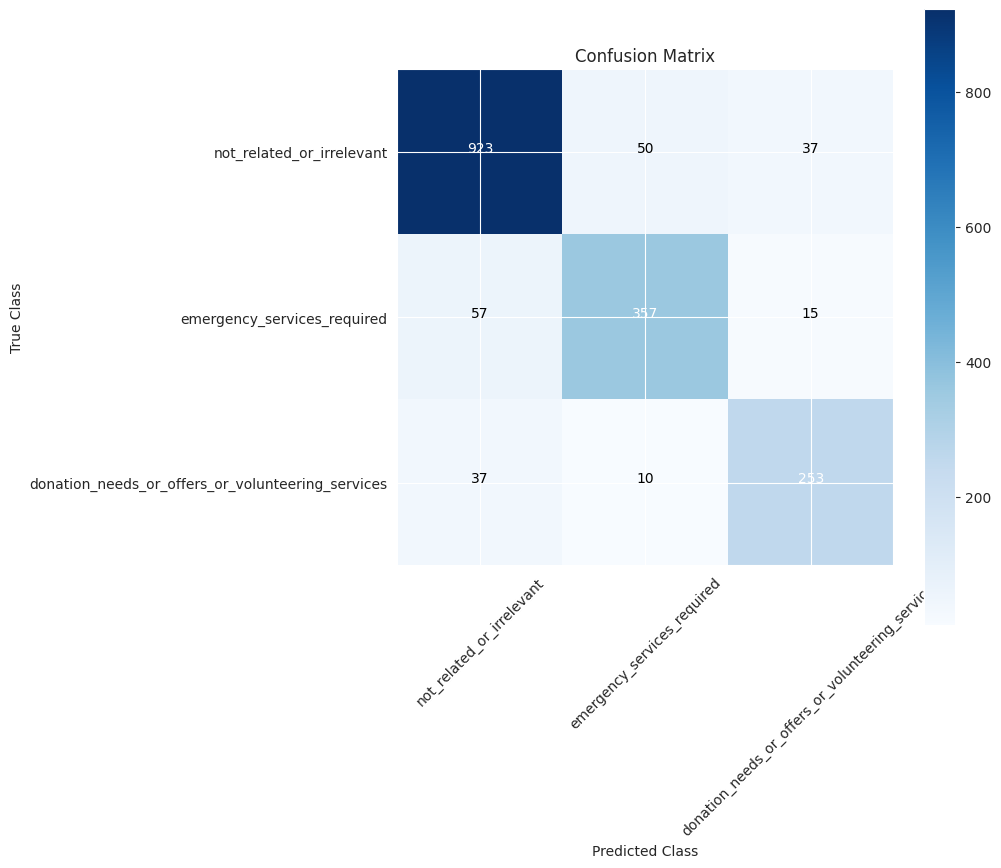

In [ ]:
# Visualize confusion matrix with numbers
class_names = ['not_related_or_irrelevant', 'emergency_services_required', 'donation_needs_or_offers_or_volunteering_services']


plt.figure(figsize=(8, 8))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers to the confusion matrix
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, str(confusion_mat[i, j]), horizontalalignment="center", color="white" if i == j else "black")

plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(test_labels, predicted_class_indices)

# Print the results
for i in range(len(class_names)):
    print(f"Class {i}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")

Class 0:
Precision: 0.9075712881022615
Recall: 0.9138613861386139
F1 Score: 0.9107054760730144
Class 1:
Precision: 0.8561151079136691
Recall: 0.8321678321678322
F1 Score: 0.8439716312056738
Class 2:
Precision: 0.8295081967213115
Recall: 0.8433333333333334
F1 Score: 0.8363636363636364


In [ ]:
correct_predictions = np.sum(np.diag(confusion_mat))
total_predictions = np.sum(confusion_mat)
accuracy = correct_predictions / total_predictions
print(accuracy)

0.8815411155836688


In [ ]:
# this is code for threshold basde predictions

[[-0.8694436  -2.7667975   2.8001432 ]
 [-0.7453643   3.7412672  -2.460814  ]
 [ 3.224219   -1.4008743  -1.9217681 ]
 ...
 [ 2.813068   -0.33153084 -2.4799998 ]
 [ 3.930483   -2.0404708  -1.9377896 ]
 [-1.359604    4.199219   -2.073095  ]]
---------------------------------------------------------
[[4.1918471e-01 6.2862992e-02 1.6447002e+01]
 [4.7456139e-01 4.2151371e+01 8.5365430e-02]
 [2.5133938e+01 2.4638146e-01 1.4634798e-01]
 ...
 [1.6660954e+01 7.1782398e-01 8.3743244e-02]
 [5.0931580e+01 1.2996750e-01 1.4402196e-01]
 [2.5676244e-01 6.6634285e+01 1.2579583e-01]]
---------------------------------------------------------
[2 1 0 ... 1 0 1]


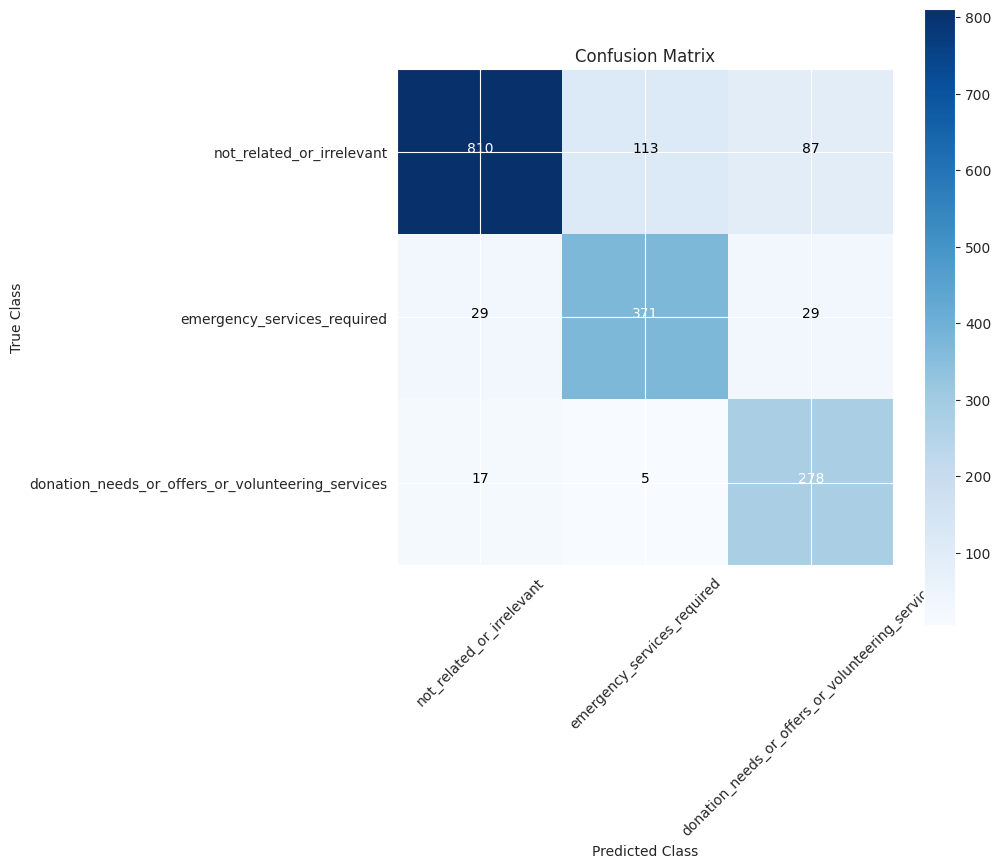

In [ ]:
# Get predictions on the test dataset
# test_predictions = trainer.predict(eval_d)
# test_logits = test_predictions.predictions
# test_labels = eval_d["label"]
# predicted_class_indices = np.argmax(test_logits, axis=-1)


from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define thresholds for each class
thresholds = [0.4, 0.6, 0.5]

# Get predictions on the test dataset
#test_predictions = trainer.predict(eval_d)
test_logits = test_predictions.predictions
test_probs = np.exp(test_logits) # convert logits to probabilities

print(test_logits)
print('---------------------------------------------------------')
print(test_probs)
print('---------------------------------------------------------')
# Apply thresholds to predictions
test_preds_thresh = np.zeros_like(predicted_class_indices)
for i in range(test_probs.shape[0]):
    for j in range(test_probs.shape[1]):
        if test_probs[i,j] >= thresholds[j]:
            test_preds_thresh[i] = j
print(test_preds_thresh)
# test_preds_thresh = np.argmax(test_preds_thresh, axis=-1)
# print(test_preds_thresh)
#test_labels = test_predictions.label_ids

# Compute confusion matrix
confusion_mat = confusion_matrix(test_labels, test_preds_thresh)

# Visualize confusion matrix with numbers
class_names = ['not_related_or_irrelevant', 'emergency_services_required', 'donation_needs_or_offers_or_volunteering_services']
plt.figure(figsize=(8, 8))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers to the confusion matrix
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, str(confusion_mat[i, j]), horizontalalignment="center", color="white" if i == j else "black")

plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_preds_thresh)

# Print the results
for i in range(len(class_names)):
    print(f"Class {i}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")

Class 0:
Precision: 0.9462616822429907
Recall: 0.801980198019802
F1 Score: 0.8681672025723473
Class 1:
Precision: 0.7586912065439673
Recall: 0.8648018648018648
F1 Score: 0.8082788671023964
Class 2:
Precision: 0.7055837563451777
Recall: 0.9266666666666666
F1 Score: 0.8011527377521614
